In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

## Boundary

In [2]:
nf = 18
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [3]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 70
t0, te = 0, 1.
N = 10
timegrid = np.linspace(0, 1)  # np.linspace(t0,te, N)

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='MQ')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

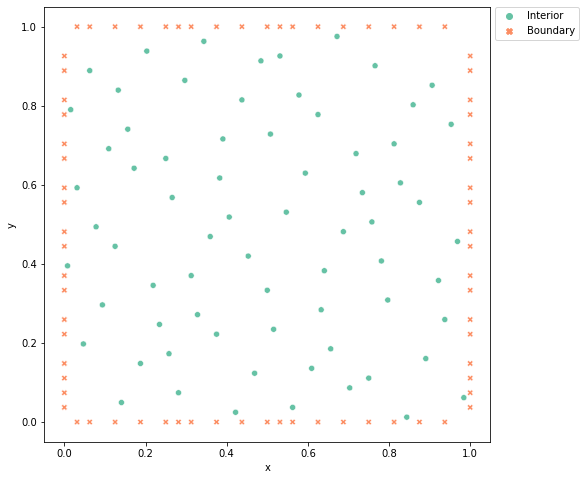

In [4]:
points = pd.concat([interior_points, boundary_points])
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation', style='Collocation', palette='Set2')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [5]:
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [7]:
exp_RK.solve()

In [8]:
exp_RK.solution

array([[[0.3232423 , 0.21443156],
        [0.20160894, 0.36752181],
        [0.43261975, 0.10685337],
        ...,
        [0.1449453 , 0.4372345 ],
        [0.38192144, 0.18873084],
        [0.263321  , 0.34360001]],

       [[0.33273826, 0.22064135],
        [0.2111049 , 0.3737316 ],
        [0.44211571, 0.11306315],
        ...,
        [0.15444126, 0.44344428],
        [0.3914174 , 0.19494063],
        [0.27281696, 0.3498098 ]],

       [[0.34244088, 0.226986  ],
        [0.22080752, 0.38007625],
        [0.45181833, 0.1194078 ],
        ...,
        [0.16414387, 0.44978894],
        [0.40112002, 0.20128528],
        [0.28251958, 0.35615445]],

       ...,

       [[0.40525606, 0.26805535],
        [0.2836227 , 0.4211456 ],
        [0.51463351, 0.16047715],
        ...,
        [0.22695906, 0.49085829],
        [0.4639352 , 0.24235463],
        [0.34533476, 0.3972238 ]],

       [[0.4165373 , 0.27543008],
        [0.29490395, 0.42852033],
        [0.52591476, 0.16785188],
        .

In [ ]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for ind in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='u', data=dff)
    return df

def u(Mi, norm_x, t, alpha=1):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')